In [63]:
# constructing a fermionic Hamiltonian operator of hydrogen molecule
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper

H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=0, multiplicity=1, units=DistanceUnit.ANGSTROM)
H2_driver = PySCFDriver.from_molecule(H2_moleculeinfo, basis="sto3g")
H2_problem = H2_driver.run()
# view property information from PySCFDriver
print(f"Nuclear Repulsion Energy from PySCFDriver: {H2_problem.nuclear_repulsion_energy:.6f} Hartree")
print(f"Reference Energy (AKA Total Ground State Energy) from PySCFDriver: {H2_problem.reference_energy:.6f} Hartree")
print(f"Electronic Ground State Energy from PySCFDriver: {(H2_problem.reference_energy - H2_problem.nuclear_repulsion_energy):.6f} Hartree")

Nuclear Repulsion Energy from PySCFDriver: 0.719969 Hartree
Reference Energy (AKA Total Ground State Energy) from PySCFDriver: -1.116999 Hartree
Electronic Ground State Energy from PySCFDriver: -1.836968 Hartree


In [64]:
# convert fermionic Hamiltonian to qubit Hamiltonian using Qiskit Nature
def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
  if show:
    print("Qubit Hamiltonian operator")
    print("{} transformation ". format(mapper_name))

  match mapper_name:
    case "Jordan-Wigner":
      mapper = JordanWignerMapper()
    case "Parity":
      mapper = ParityMapper(num_particles=problem.num_particles)
    case "Bravyi-Kitaev":
      mapper = BravyiKitaevMapper()
  
  qubit_op = mapper.map(second_q_op)
  
  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)
    
  n_items = len(qubit_op)
  if show:
    print("Number of items in the Pauli list:", n_items)
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])
  return qubit_op, mapper
# reference
H2_fermionic_hamiltonian = H2_problem.hamiltonian
H2_second_q_op = H2_fermionic_hamiltonian.second_q_op()
# independently computed
qubit_hamiltonian, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Parity", two_qubit_reduction=True)
num_qubits = qubit_hamiltonian.num_qubits

Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


In [ ]:
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt

# print qubit hamiltonian information
print(f"--- VQE for H2 Ground State Energy ---")
print(f"Simulating H2 molecule Hamiltonian ({num_qubits} qubits)")
print("Hamiltonian:\n", qubit_hamiltonian.paulis)
print("Coefficients:\n", qubit_hamiltonian.coeffs)

# initialize ansatz circuit
ansatz = EfficientSU2(num_qubits=num_qubits, entanglement='linear', reps=2)
print("\n--- Ansatz Circuit ---")
print(f"Using EfficientSU2 with {ansatz.num_parameters} parameters.")
print(ansatz.decompose())

# initialize optimizer and estimator
optimizer = SLSQP()
estimator = Estimator()

# helper function to print values over each iteration
intermediate_values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    if eval_count % 25 == 0: # Store every 25 evaluations
         print(f"Iteration {eval_count}: Energy = {mean:.6f}")
    intermediate_values.append(mean)

# initialize VQE
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=store_intermediate_result
)

--- VQE for H2 Ground State Energy ---
Simulating H2 molecule Hamiltonian (2 qubits)
Hamiltonian:
 ['II', 'IZ', 'ZI', 'ZZ', 'XX']
Coefficients:
 [-1.05237325+0.j  0.39793742+0.j -0.39793742+0.j -0.0112801 +0.j
  0.1809312 +0.j]

--- Ansatz Circuit ---
Using EfficientSU2 with 12 parameters.
     ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──┤ Ry(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ Rz(θ[10]) ├
«     ├───────────┤
«q_1: ┤ Rz(θ[11]) ├
«     └───────────┘



--- Running VQE ---
Iteration 25: Energy = -1.580674
Iteration 50: Energy = -1.753363
Iteration 75: Energy = -1.851648
Iteration 100: Energy = -1.857263

--- VQE Results ---
Estimated Electronic Ground State Energy (using VQE): -1.857275 Hartree
Exact Electronic Ground State Energy (using FCI/from PySCFDriver): -1.836968 Hartree
Absolute Error: 0.020307 Hartree
Number of Optimizer Evaluations: 118


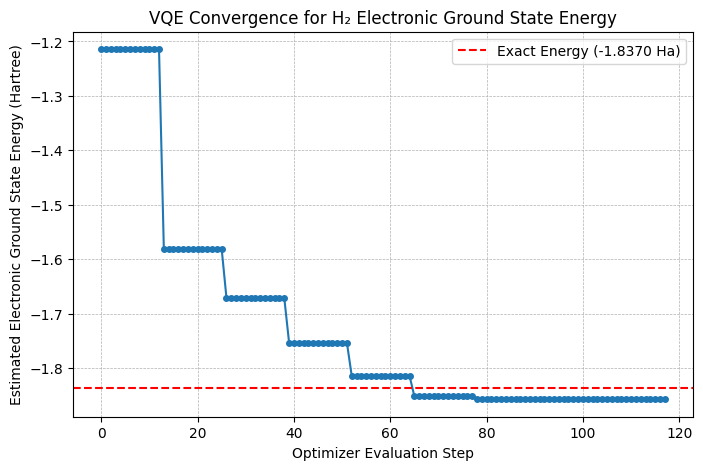

In [66]:
# run VQE and analyze the results
print("\n--- Running VQE ---")
result = vqe.compute_minimum_eigenvalue(operator=qubit_hamiltonian)
print("\n--- VQE Results ---")
vqe_value = result.eigenvalue.real
print(f"Estimated Electronic Ground State Energy (using VQE): {vqe_value:.6f} Hartree")
exact_value = (H2_problem.reference_energy - H2_problem.nuclear_repulsion_energy)
print(f"Exact Electronic Ground State Energy (using FCI/from PySCFDriver): {exact_value:.6f} Hartree")
error = abs(vqe_value - exact_value)
print(f"Absolute Error: {error:.6f} Hartree")
print(f"Number of Optimizer Evaluations: {result.cost_function_evals}")

# plot the values over time
plt.figure(figsize=(8, 5))
plt.plot(range(len(intermediate_values)), intermediate_values, marker='o', linestyle='-', markersize=4)
plt.axhline(y=exact_value, color='r', linestyle='--', label=f'Exact Energy ({exact_value:.4f} Ha)')
plt.xlabel("Optimizer Evaluation Step")
plt.ylabel("Estimated Electronic Ground State Energy (Hartree)")
plt.title("VQE Convergence for H₂ Electronic Ground State Energy")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()